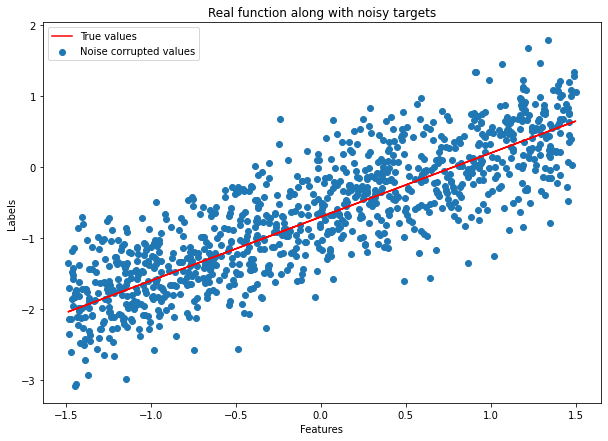

In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal

import pandas as pd
import seaborn as sns

import random

# Generate noisy dataset
seed = 42
np.random.seed(seed)

n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5


train_points = np.random.uniform(lower_bound, upper_bound, n_datapoints)
noisy_labels = slope * train_points + intercept + np.random.normal(0, noise_std_dev, n_datapoints)
true_labels = slope * train_points + intercept

# Plot the dataset
plt.figure(figsize=(10,7))
plt.plot(train_points, true_labels, color='r', label="True values")
plt.scatter(train_points, noisy_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();


In [21]:
feature_dim = 2

feature_matrix = np.stack((np.ones(n_datapoints),train_points), axis=1)

precision = 0.2
prior_mean = np.zeros(feature_dim)
prior_cov = np.identity(feature_dim) * (1.0/precision)

prior = multivariate_normal(prior_mean, prior_cov)



In [22]:
inverse_mat = np.linalg.inv(np.dot(feature_matrix.T, feature_matrix) + noise_var * precision * np.identity(feature_dim))

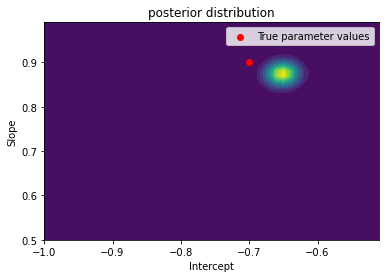

In [23]:
# Compute the posterior distribution
posterior_mean = np.dot(inverse_mat, np.dot(feature_matrix.T, noisy_labels))
posterior_cov = noise_var * inverse_mat

posterior = multivariate_normal(posterior_mean, posterior_cov)

# Plot the posterior distribution
fig = plt.figure()
mesh_features, mesh_labels = np.mgrid[-1.0:-0.5:.01, 0.5:1.0:.01]
pos = np.dstack((mesh_features, mesh_labels))
plt.contourf(mesh_features, mesh_labels, posterior.pdf(pos), levels=15)
plt.scatter(intercept, slope, color='red', label="True parameter values")
plt.title("posterior distribution")
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

In [24]:
# Check posterior predictive distribution
n_test_points = 10

test_points = np.random.uniform(lower_bound, upper_bound, n_test_points)



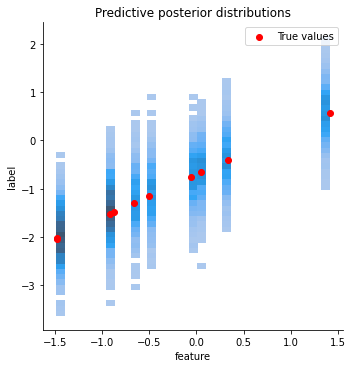

In [25]:
all_rows = []
sample_size = 1000

true_labels = slope * test_points + intercept

for point in test_points:
    test_features = np.stack((np.ones(1), np.array([point])), axis=1)
    pred_mean = test_features.dot(posterior_mean)
    pred_cov = test_features.dot(posterior_cov.dot(test_features.T)) + noise_var
    predictive = univariate_normal(pred_mean.flatten(), math.sqrt(pred_cov))
    
    sample_predicted_labels = predictive.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([point, label])
    
all_data = pd.DataFrame(all_rows, columns=["feature", "label"]) 
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=test_points, y=true_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot();


In [26]:
# Compute log marginal likelihood
log_ml = 0
for i in range(0, n_datapoints):
    train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
    pred_mean = train_features.dot(posterior_mean)
    pred_cov = train_features.dot(posterior_cov.dot(train_features.T)) + noise_var
    predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))
    
    true_label = train_points[i] * slope + intercept
    # print("true output: " + str(true_label), "pred mean: " + str(pred_mean), "pred covariance: " + str(pred_cov), "pred probability: " + str(predictive.pdf(true_label)))
    log_ml += math.log(predictive.pdf(true_label))
    
print("Log Marginal Likelihood on the training set: " + str(log_ml))

Log Marginal Likelihood on the training set: -232.7000606474509


# Harmonic Mean Estimator

We want to estimate the marginal likelihood, because normally it is impossible to analytically calculate its exact value for arbitrary distributions. The Harmonic Mean Estimator is an estimator based on Simple Importance Sampling (SIS), which can estimate the marginal likelihood through the posterior and the prior. The formula below shows the relation between these three distributions:
\begin{equation}
 E_{\omega \sim p(\omega|y)}\left[ \frac{p(\omega)}{p(\omega, y)}\right] = \frac{1}{p(y)}
\end{equation}

Following this formula we first sample from the posterior $p(\omega, y)$ and then calculate the ratio of prior and posterior, which is the reciprocal of the predictive distribution:
\begin{equation}
 \frac{p(\omega)}{p(\omega,y)} = \frac{1}{p(y|\omega)}
\end{equation}

Therefore we evaluate the sample-specific predictive distribution at the target location and add the results together to obtain the unbiased estimation of the reciprocal of the marginal likelihood.

To compute the predictive distribution over all data points with given model parameter, we use the following formula:
\begin{equation}
 p(y|\omega) = \prod_{i = 1}^{N}p(y_i|\omega) = \exp{\sum_{i = 1}^{N} \log(p(y_i|\omega))}
\end{equation}
We first sum up in log space, because directly calculating the product of the value for each data point might lead to numerical underflow.


In [27]:
# Harmonic Mean Estimator

# Samples need to be from the posterior
def harmonic_mean_estimator(samples):
    denominator = 0
    for k in range(0, len(samples)):
        sum_logs = 0

        print("current sample: " + str(samples[k]))
        for i in range(0, n_datapoints):
            train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
            true_label = train_points[i] * slope + intercept
            pred_mean = train_features.dot(samples[k])
            pred_cov = noise_var
            predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

            sum_logs += math.log(predictive.pdf(true_label))

        dataset_likelihood = math.exp(sum_logs)
        denominator += 1.0 / dataset_likelihood

    ML_estimate = K / denominator
    return ML_estimate


# With ground truth samples
K = 20
true_samples = posterior.rvs(size=K)
ML_estimate = harmonic_mean_estimator(true_samples)
print("Estimated Log Marginal Likelihood on the training set: " + str(math.log(ML_estimate)))

current sample: [-0.63532621  0.86021307]
current sample: [-0.63706157  0.90160621]
current sample: [-0.631156    0.84338768]
current sample: [-0.64747054  0.90238564]
current sample: [-0.65696843  0.89895863]
current sample: [-0.66734052  0.84213635]
current sample: [-0.67077621  0.90807742]
current sample: [-0.65074153  0.87407177]
current sample: [-0.65936453  0.86580412]
current sample: [-0.65991894  0.87653632]
current sample: [-0.65107542  0.84821059]
current sample: [-0.63526462  0.89171688]
current sample: [-0.67267606  0.86204945]
current sample: [-0.62735336  0.86599867]
current sample: [-0.63881137  0.88436283]
current sample: [-0.6427027   0.88929658]
current sample: [-0.64063339  0.87502318]
current sample: [-0.6746455   0.86709646]
current sample: [-0.6302789   0.88471381]
current sample: [-0.64089337  0.85248252]
Estimated Log Marginal Likelihood on the training set: -237.80814434798125


# Markov Chain Monte Carlo
In practice we usually cannot sample from the true posterior, because we cannot compute it analytically. Therefore, we use Markov Chain Monte Carlo (MCMC) sampling to obtain approximate samples from the posterior without knowing its true form. The only constraint is that we have to be able to evaluate a function $f$ that is proportional to the posterior. The posterior can be decomposed using Bayes rule to this: 
\begin{equation}
p(w|X, y) = {p(y|X, w)p(w) \over p(y|X)} = {p(y|X, w)p(w) \over \int p(y|X, w)p(w)dw}
\end{equation}
Even if we do not know the analytical form of the posterior because we cannot solve the integral in the denominator, we can still evaluate the numerator. Since it is proportional to the posterior, it is valid for us to define 
\begin{equation}
f(w) = p(y|X, w)p(w)
\end{equation}

We use the Metropolis algorithm to define our acceptance probabilities and thereby also our transition probabilities of the Markov Chain. The idea is to define the transition probabilities such that the Markov Chain's stationary distribution is identical to our target distribution, the posterior distribution. This can be achieved by fulfilling the "detailed balance condition": $p(a)T(a \rightarrow b) = p(b)T(b \rightarrow a)$, where $T(a \rightarrow b)$ denotes the probability of transitioning from a to b. Let $g(b|a)$ denote our proposal distribution for a new sample b given the current sample a. Additionally, let $A(a \rightarrow b)$ denote the probability of accepting such a transition from a to b. Using our proportional function $f$ and the above definitions, the detailed balance condition can be written as such:

\begin{equation}
{f(a) \over NC})g(b|a)A(a \rightarrow b) = {f(b) \over NC}g(a|b)A(b \rightarrow a)
\end{equation}

The Metropolis algorithm derives acceptance probabilities that fulfill the above condition:
\begin{equation}
A(a \rightarrow b) = min(1, {f(b) \over f(a)})
\end{equation}

The proposal distribution needs to be symmetric for the above definition, in the code below we simply use a Gaussian distribution centered at the current sample with a small variance: $g(b|a) = \mathcal{N}(b|a, 0.05 \cdot I)$

By defining the transition probabilities as described above, we achieve that our Markov Chain has the posterior distribution as its stationary distribution. This means once the chain has converged to the stationary distribution, the distribution of states over many iterations of the Markov Chain will resemble the posterior distribution. The visited states can be used as approximate samples from the posterior distribution. Since the Markov Chain needs to converge to the stationary distribution first, it is common practice to discard the first $m$ iterations of the Markov Chain, where $m$ is a large number. We use $m=400$ in the code below. This initial phase is commonly referred to as the "Burn-In" phase. For our toy example, we let the Markov Chain run for 500 iterations and discard the first 400 steps. Thus, we obtain 100 approximate samples from the posterior distribution.

We observe that the last 100 samples are identical in some runs, which means none of the last 100 proposed samples was accepted. We assume that this might be due to our proposal distribution having too much variance, i.e. once we have converged to the value with the highest probability, it is very unlikely that it will propose another value with a probability that is not much smaller. We assume that this effect is amplified by the fact that our true posterior is a very narrow distribution, since we have observed $n=1000$ datapoints and only have to estimate 2 parameters (slope and intercept).

Every computation of $f(w)$ involves computing $p(y|X, w)$. Since $y$ denotes the ground truth labels of the entire dataset, we actually need to compute $p(y|X, w) = \prod_{i=1}^n p(y_i|X, w)$. To avoid a numerical underflow when multiplying very small numbers repeatedly, we rewrite the expression to $exp(log(\prod_{i=1}^n p(y_i|X, w))) = exp(\sum_{i=1}^{n} log(p(y_i|X, w)))$. Still, taking the exponential of a large negative number can result in an underflow. Since we are never interested in the exact value of $f$ but rather the ratio of $f$ evaluated at two different locations $a$ and $b$, we can also avoid this evaluation:

\begin{equation}
{f(b) \over f(a)} = {\prod_{i=1}^n p(y_i|X, b) \over \prod_{i=1}^n p(y_i|X, a)} = {exp(\sum_{i=1}^{n} log(p(y_i|X, b))) \over exp(\sum_{i=1}^{n} log(p(y_i|X, a)))} = exp(\sum_{i=1}^{n} log(p(y_i|X, b)) - \sum_{i=1}^{n} log(p(y_i|X, a)))
\end{equation}

While this fixes the underflow issue, it can now happen that the second sum of logs is so much smaller than the first one, that the difference is a large positive number and an overflow happens when evaluating the $exp$ function. Therefore, we implement a last trick to account for this: We defined our acceptance probability as $A(a \rightarrow b) = min(1, {f(b) \over f(a)})$. The second expression inside the $min$ only needs to be evaluated if it is smaller than 1. To check, whether ${f(b) \over f(a)} < 1$, it is equivalent to check, whether $\sum_{i=1}^{n} log(p(y_i|X, b)) - \sum_{i=1}^{n} log(p(y_i|X, a)) < log({p(b) \over p(a)})$. In other words, we only need to evaluate the $exp$ expression if the difference between the sum of logs is negative or zero, thus we also avoid the overflow problem.

In [28]:
# With MCMC samples

current_sample = prior.rvs()
print("initial sample: " + str(current_sample))

# Loop over dataset to calculate dataset likelihood for a given sample
sum_logs = 0
for i in range(0, n_datapoints):
    train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
    true_label = train_points[i] * slope + intercept
    pred_mean = train_features.dot(current_sample)
    pred_cov = noise_var
    predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

    sum_logs += math.log(predictive.pdf(true_label))
    
log_dataset_likelihood_current = sum_logs
print("log dataset_likelihood: " + str(log_dataset_likelihood_current))

posterior_samples = []

# Iterations of Markov Chain
for j in range(0, 500):
    
    proposal_sample = multivariate_normal(current_sample, np.identity(2) * 0.05).rvs()
    
    # Loop over dataset to calculate dataset likelihood for a given sample
    sum_logs = 0
    for i in range(0, n_datapoints):
        train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
        true_label = train_points[i] * slope + intercept
        pred_mean = train_features.dot(proposal_sample)
        pred_cov = noise_var
        predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

        sum_logs += math.log(predictive.pdf(true_label))
        
    log_dataset_likelihood_proposal = sum_logs
    
    # Calculate the ratio of f_proposal and f_current. We avoid computing f directly, 
    # because it involves taking exp of a large negative number and will yield zero.
    difference = log_dataset_likelihood_proposal - log_dataset_likelihood_current
    prior_ratio = prior.pdf(proposal_sample) / prior.pdf(current_sample)
    
    if difference < math.log(prior_ratio):
        f_ratio = math.exp(log_dataset_likelihood_proposal - log_dataset_likelihood_current) * prior_ratio
    else: 
        f_ratio = 1
    
    acceptance_prob = min(1.0, f_ratio)
    r = random.uniform(0, 1)
    
    if r < acceptance_prob: # accept
        current_sample = proposal_sample
        log_dataset_likelihood_current = log_dataset_likelihood_proposal
    
    posterior_samples.append(current_sample)
    print(current_sample)

initial sample: [ 3.75830639 -0.00502266]
log dataset_likelihood: -41708.93293309101
[3.57539554 0.02248515]
[ 3.4522924  -0.11541989]
[ 3.4522924  -0.11541989]
[ 3.12942008 -0.11110632]
[ 3.12443174 -0.03428518]
[ 3.12443174 -0.03428518]
[ 3.12443174 -0.03428518]
[ 3.12443174 -0.03428518]
[ 3.12443174 -0.03428518]
[ 3.12443174 -0.03428518]
[ 2.61388406 -0.08201018]
[ 2.61388406 -0.08201018]
[ 2.61388406 -0.08201018]
[ 2.61388406 -0.08201018]
[2.56081943 0.14784844]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.47315488 0.15418104]
[2.4295986  0.08591184]
[2.4295986  0.08591184]
[2.4295986  0.08591184]
[2.35547308 0.1038814 ]
[2.36453429 0.27408509]
[2.33755768 0.19584835]
[2.29712791 0.03604459]
[2.21664934 0.49022549]
[2.01256817 0.42791604]
[1.92592307 0.37264678]
[1.85185571 0.43508677]
[1.46944893 0.66700536]
[1.46944893 0.66700536]
[

[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.69376398  0.91675511]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231   0.90357878]
[-0.7289231 

In [29]:
ML_estimate = harmonic_mean_estimator(posterior_samples[-100:])
print("Estimated Log Marginal Likelihood on the training set: " + str(math.log(ML_estimate)))

current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90185507]
current sample: [-0.72711932  0.90

# Annealed Importance sampling
Annealed importance sampling combines the concepts of MCMC sampling and importance weights. It gives us a stochastic lower bound of the marginal likelihood. This means with infinite samples, the probability of overestimating the true ML goes down to zero. The idea of annealed importance sampling is using a series of intermediate distributions to bridge between prior and posterior distribution, because it is inefficient to use a single importance sampling computation between two very dissimilar distributions.
This algorithm takes as input a sequence of T distributions $p_0$,...,$p_T$, with $p_t(x) = f_t(x) / Z_t$, where $p_T$ is the target distribution (posterior $p(\omega|y, x)$) and $p_0$ is the proposal distribution(prior $p(\omega)$) and the intermediate distributions are taken to be geometric averages of the initial and target distribution: $f_t(\omega) = f_0(\omega)^{1-\beta_t}f_T(\omega)^{\beta_t}$, where $\beta$ are monotonically increasing parameters with $\beta_0 = 0$ and $\beta_T = 1$, in our case we take $\beta_t = t/T$ and we can represent intermediate distribution with prior and posterior
\begin{equation}
f_t(\omega) = f_0(\omega)^{1-\beta_t}f_T(\omega)^{\beta_t}
\end{equation}
\begin{equation}
f_0(\omega) = p(\omega)
\end{equation}
\begin{equation}
f_T(\omega) = p(y|\omega,x)p(\omega)
\end{equation}
When we insert the last two equations into the first one, we get the following representation:
\begin{equation}
f_t(\omega) = p(\omega)^{1-\beta_t}(p(y|\omega,x)p(\omega))^{\beta_t} \\
==> f_t(\omega) = p(\omega)p(y|\omega,x)^{\beta_t}
\end{equation}


## Explanation of the Algorithm
After defining these intermediate distributions, we would like to introduce the algorithm itself.
This algorithm can be divided into an outer loop and and inner loop. The outer loop calculates the Monte Carlo estimator of the expectation of parameter x and the inner loop is an MCMC process designed to tranform a sample from the prior to one of the posterior.
### Inner loop
We introduce the inner loop first. Since we have several intermediate distributions, we need to do MCMC between them in order to calculate the final weight as the product of weights for each MCMC transition. The weight for each MCMC transition is defined as below:
\begin{equation}
w_t^{(k)} = \frac {f_t(x_{t-1})} {f_{t-1}(x_{t-1})} = \frac {p(w)p(y|\omega, x)^{\beta_t}} {p(\omega)p(y|\omega, x)^{\beta_{t-1}}} = p(y|\omega, x)^{\beta_t-\beta_{t-1}}
\end{equation}
Since we have $\beta_t = \frac t T$, we can equivalently write $w_t^{(k)} = p(y|\omega, x)^{1/T}$ and in log space it becomes
\begin{equation}
log(w_t^{(k)}) = 1/T * log(p(y|\omega, x))
\end{equation}
After we have the weight of the MCMC step, we need to transition to the next state based on the current state, which we use the afore mentioned Metropolis algorithm for. The transition probability is defined as
\begin{equation}
\frac{f_t(x_p)}{f_t(x_c)} = \frac{p(\omega_p)p(y|\omega_p, x)^{\beta_t}}{p(\omega_c)p(y|\omega_c, x)^{\beta_t}}
\end{equation}
The proposal for the next state will be sampled from a normal distribution, whose mean is the current sample and whose standard derivation is fixed as a hyperparameter (current setting is an identity matrix multiplied with 0.05).
When the inner loop is finished, we can obtain a cumulated weight for the sample $\omega_k$.
\begin{equation}
\omega_k = \prod_{t = 2}^{T} \frac {f_t(x_{t-1})} {f_{t-1}(x_{t-1})}  ==> log(\omega_k) = \sum_{t=2}^{T} log(\frac {f_t(x_{t-1})} {f_{t-1}(x_{t-1})} ) ==> log(\omega_k) = \sum_{t=2}^{T}1/T * log(p(y|\omega, x))
\end{equation}
### Outer loop
The outer loop is rather simple, it samples K times from the prior and then does the inner loop. Afer we have multiple weights, we take the average of these weights to be our estimator.

In [11]:
# Annealed Importance Sampling

# K and T are hyperparameters, K for MC estimate, T is number of intermediate distributions
def annealed_importance_sampling(prior, K, T):
    # Outer loop for MC estimate of E[w]
    omega_list = []
    for k in range(0, K): 
        x = prior.rvs()
        log_omega = 0
        
        for t in range(1, T):
            print("Current sample: " + str(x) + " chain " + str(k) + ", sample " + str(t))
            log_omega = log_omega + evaluate_intermediate_ratio(x, T)
            x = transition_sample(prior, x, t, T)

        print("Finished simulating chain, omega sample is: " + str(math.exp(log_omega)) + ", log omega: " + str(log_omega))
        omega_list.append(math.exp(log_omega))
        
    Z_estimator = sum(omega_list) / len(omega_list)
    print(omega_list)
    print("ML estimate: " + str(Z_estimator))
    print("Log ML estimate: " + str(math.log(Z_estimator)))

def evaluate_intermediate_ratio(x, T):
    log_dataset_likelihood = get_log_dataset_likelihood(x)
    intermediate_ratio = (1.0 / T) * log_dataset_likelihood
    print("log dataset likelihood: " + str(log_dataset_likelihood) + ", intermediate_ratio: " + str(intermediate_ratio))
    return intermediate_ratio


def transition_sample(prior, current_sample, t, T, n_steps=10):
    log_dataset_likelihood_current = get_log_dataset_likelihood(current_sample)
    for i in range(0, n_steps):
        proposal_sample = multivariate_normal(current_sample, np.identity(2) * 0.05).rvs()
        log_dataset_likelihood_proposal = get_log_dataset_likelihood(proposal_sample)
        beta_t = float(t) / T
    
        log_prior_ratio = math.log(prior.pdf(proposal_sample)) - math.log(prior.pdf(current_sample))
        log_f_ratio = log_prior_ratio + beta_t * (log_dataset_likelihood_proposal - log_dataset_likelihood_current)
    
        # We only need to evaluate f_ratio if its log is smaller than 0, otherwise f_ratio is larger than 1
        if(log_f_ratio < 0):
            f_ratio = math.exp(log_f_ratio)
        else:
            f_ratio = 1
    
        acceptance_prob = f_ratio
        r = random.uniform(0, 1)

        if r < acceptance_prob: # accept
            current_sample = proposal_sample
            log_dataset_likelihood_current = log_dataset_likelihood_proposal
    
    return current_sample

# This for-loop should be removed/vectorized!!
def get_log_dataset_likelihood(parameter_val):
    # Loop over dataset to calculate dataset likelihood for a given sample
    sum_logs = 0
    for i in range(0, n_datapoints):
        train_features = np.stack((np.ones(1), np.array([train_points[i]])), axis=1)
        true_label = train_points[i] * slope + intercept
        pred_mean = train_features.dot(parameter_val)
        pred_cov = noise_var
        predictive = univariate_normal(pred_mean, math.sqrt(pred_cov))

        sum_logs += math.log(predictive.pdf(true_label))

    log_dataset_likelihood = sum_logs
    # print("log_dataset_likelihood: " + str(log_dataset_likelihood))
    return log_dataset_likelihood
    

In [35]:
annealed_importance_sampling(prior, 10, 200)   

Current sample: [ 0.86190162 -0.55781543] chain 0, sample 1
log dataset likelihood: -8636.221368001938, intermediate_ratio: -43.18110684000969
Current sample: [ 0.01200669 -0.10236411] chain 0, sample 2
log dataset likelihood: -2866.785797285231, intermediate_ratio: -14.333928986426157
Current sample: [-0.24243992 -0.03471721] chain 0, sample 3
log dataset likelihood: -2036.839597817024, intermediate_ratio: -10.18419798908512
Current sample: [-0.53791199  0.93019807] chain 0, sample 4
log dataset likelihood: -279.16514715790436, intermediate_ratio: -1.3958257357895218
Current sample: [-0.78864037  0.95566577] chain 0, sample 5
log dataset likelihood: -246.843212287955, intermediate_ratio: -1.234216061439775
Current sample: [-0.71628291  0.8680514 ] chain 0, sample 6
log dataset likelihood: -227.82898606587713, intermediate_ratio: -1.1391449303293857
Current sample: [-0.9396523   0.90734315] chain 0, sample 7
log dataset likelihood: -340.94640615994155, intermediate_ratio: -1.7047320307

Current sample: [-0.7364825   0.94772895] chain 0, sample 58
log dataset likelihood: -232.15681933110943, intermediate_ratio: -1.1607840966555472
Current sample: [-0.7364825   0.94772895] chain 0, sample 59
log dataset likelihood: -232.15681933110943, intermediate_ratio: -1.1607840966555472
Current sample: [-0.7364825   0.94772895] chain 0, sample 60
log dataset likelihood: -232.15681933110943, intermediate_ratio: -1.1607840966555472
Current sample: [-0.7364825   0.94772895] chain 0, sample 61
log dataset likelihood: -232.15681933110943, intermediate_ratio: -1.1607840966555472
Current sample: [-0.69753828  0.93044957] chain 0, sample 62
log dataset likelihood: -227.21919371864408, intermediate_ratio: -1.1360959685932204
Current sample: [-0.69753828  0.93044957] chain 0, sample 63
log dataset likelihood: -227.21919371864408, intermediate_ratio: -1.1360959685932204
Current sample: [-0.69753828  0.93044957] chain 0, sample 64
log dataset likelihood: -227.21919371864408, intermediate_ratio

log dataset likelihood: -227.45507720096808, intermediate_ratio: -1.1372753860048403
Current sample: [-0.68183362  0.92626008] chain 0, sample 115
log dataset likelihood: -227.45507720096808, intermediate_ratio: -1.1372753860048403
Current sample: [-0.66668414  0.89115807] chain 0, sample 116
log dataset likelihood: -228.16580089303142, intermediate_ratio: -1.140829004465157
Current sample: [-0.66668414  0.89115807] chain 0, sample 117
log dataset likelihood: -228.16580089303142, intermediate_ratio: -1.140829004465157
Current sample: [-0.65721162  0.92318515] chain 0, sample 118
log dataset likelihood: -230.16292714001747, intermediate_ratio: -1.1508146357000875
Current sample: [-0.65721162  0.92318515] chain 0, sample 119
log dataset likelihood: -230.16292714001747, intermediate_ratio: -1.1508146357000875
Current sample: [-0.65721162  0.92318515] chain 0, sample 120
log dataset likelihood: -230.16292714001747, intermediate_ratio: -1.1508146357000875
Current sample: [-0.65721162  0.923

Current sample: [-0.70812966  0.87120463] chain 0, sample 171
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 172
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 173
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 174
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 175
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 176
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.135850402274328
Current sample: [-0.70812966  0.87120463] chain 0, sample 177
log dataset likelihood: -227.1700804548656, intermediate_ratio: -1.1

Current sample: [-0.74811391  0.94200793] chain 1, sample 28
log dataset likelihood: -233.36874500921763, intermediate_ratio: -1.1668437250460881
Current sample: [-0.62454998  0.89529741] chain 1, sample 29
log dataset likelihood: -237.25222467241758, intermediate_ratio: -1.1862611233620879
Current sample: [-0.62454998  0.89529741] chain 1, sample 30
log dataset likelihood: -237.25222467241758, intermediate_ratio: -1.1862611233620879
Current sample: [-0.70960985  0.98419171] chain 1, sample 31
log dataset likelihood: -236.9608055049181, intermediate_ratio: -1.1848040275245906
Current sample: [-0.62199384  0.91485513] chain 1, sample 32
log dataset likelihood: -238.16482531901988, intermediate_ratio: -1.1908241265950994
Current sample: [-0.62199384  0.91485513] chain 1, sample 33
log dataset likelihood: -238.16482531901988, intermediate_ratio: -1.1908241265950994
Current sample: [-0.62199384  0.91485513] chain 1, sample 34
log dataset likelihood: -238.16482531901988, intermediate_ratio:

log dataset likelihood: -227.63509901084313, intermediate_ratio: -1.1381754950542158
Current sample: [-0.72687957  0.91511936] chain 1, sample 85
log dataset likelihood: -227.63509901084313, intermediate_ratio: -1.1381754950542158
Current sample: [-0.69751847  0.89781   ] chain 1, sample 86
log dataset likelihood: -225.81167260331128, intermediate_ratio: -1.1290583630165565
Current sample: [-0.69751847  0.89781   ] chain 1, sample 87
log dataset likelihood: -225.81167260331128, intermediate_ratio: -1.1290583630165565
Current sample: [-0.69751847  0.89781   ] chain 1, sample 88
log dataset likelihood: -225.81167260331128, intermediate_ratio: -1.1290583630165565
Current sample: [-0.70981678  0.88399025] chain 1, sample 89
log dataset likelihood: -226.35950493334352, intermediate_ratio: -1.1317975246667176
Current sample: [-0.70981678  0.88399025] chain 1, sample 90
log dataset likelihood: -226.35950493334352, intermediate_ratio: -1.1317975246667176
Current sample: [-0.70981678  0.8839902

Current sample: [-0.67931877  0.93319192] chain 1, sample 141
log dataset likelihood: -228.2591416463122, intermediate_ratio: -1.1412957082315611
Current sample: [-0.67931877  0.93319192] chain 1, sample 142
log dataset likelihood: -228.2591416463122, intermediate_ratio: -1.1412957082315611
Current sample: [-0.70768013  0.91878081] chain 1, sample 143
log dataset likelihood: -226.46809222273322, intermediate_ratio: -1.132340461113666
Current sample: [-0.70768013  0.91878081] chain 1, sample 144
log dataset likelihood: -226.46809222273322, intermediate_ratio: -1.132340461113666
Current sample: [-0.70768013  0.91878081] chain 1, sample 145
log dataset likelihood: -226.46809222273322, intermediate_ratio: -1.132340461113666
Current sample: [-0.70768013  0.91878081] chain 1, sample 146
log dataset likelihood: -226.46809222273322, intermediate_ratio: -1.132340461113666
Current sample: [-0.70768013  0.91878081] chain 1, sample 147
log dataset likelihood: -226.46809222273322, intermediate_rati

log dataset likelihood: -226.26565288474856, intermediate_ratio: -1.1313282644237428
Current sample: [-0.7032207   0.91705962] chain 1, sample 198
log dataset likelihood: -226.26565288474856, intermediate_ratio: -1.1313282644237428
Current sample: [-0.7032207   0.91705962] chain 1, sample 199
log dataset likelihood: -226.26565288474856, intermediate_ratio: -1.1313282644237428
Finished simulating chain, omega sample is: 1.426388862681818e-141, log omega: -324.309352132615
Current sample: [3.85344075 1.56318866] chain 2, sample 1
log dataset likelihood: -42016.0831731222, intermediate_ratio: -210.080415865611
Current sample: [3.28135183 1.28854579] chain 2, sample 2
log dataset likelihood: -31979.188454341056, intermediate_ratio: -159.89594227170528
Current sample: [2.69715337 1.57658134] chain 2, sample 3
log dataset likelihood: -23741.64717329647, intermediate_ratio: -118.70823586648235
Current sample: [1.65461438 1.95223584] chain 2, sample 4
log dataset likelihood: -12725.59170146976

log dataset likelihood: -234.35231164421515, intermediate_ratio: -1.1717615582210759
Current sample: [-0.64220579  0.93725485] chain 2, sample 55
log dataset likelihood: -234.35231164421515, intermediate_ratio: -1.1717615582210759
Current sample: [-0.64220579  0.93725485] chain 2, sample 56
log dataset likelihood: -234.35231164421515, intermediate_ratio: -1.1717615582210759
Current sample: [-0.64220579  0.93725485] chain 2, sample 57
log dataset likelihood: -234.35231164421515, intermediate_ratio: -1.1717615582210759
Current sample: [-0.67742057  0.91486272] chain 2, sample 58
log dataset likelihood: -227.11116115957492, intermediate_ratio: -1.1355558057978745
Current sample: [-0.67742057  0.91486272] chain 2, sample 59
log dataset likelihood: -227.11116115957492, intermediate_ratio: -1.1355558057978745
Current sample: [-0.67742057  0.91486272] chain 2, sample 60
log dataset likelihood: -227.11116115957492, intermediate_ratio: -1.1355558057978745
Current sample: [-0.67742057  0.9148627

Current sample: [-0.69695846  0.91073507] chain 2, sample 167
log dataset likelihood: -225.9830907852593, intermediate_ratio: -1.1299154539262966
Current sample: [-0.69695846  0.91073507] chain 2, sample 168
log dataset likelihood: -225.9830907852593, intermediate_ratio: -1.1299154539262966
Current sample: [-0.69695846  0.91073507] chain 2, sample 169
log dataset likelihood: -225.9830907852593, intermediate_ratio: -1.1299154539262966
Current sample: [-0.66868029  0.91736389] chain 2, sample 170
log dataset likelihood: -228.15283780380386, intermediate_ratio: -1.1407641890190194
Current sample: [-0.66868029  0.91736389] chain 2, sample 171
log dataset likelihood: -228.15283780380386, intermediate_ratio: -1.1407641890190194
Current sample: [-0.66868029  0.91736389] chain 2, sample 172
log dataset likelihood: -228.15283780380386, intermediate_ratio: -1.1407641890190194
Current sample: [-0.66868029  0.91736389] chain 2, sample 173
log dataset likelihood: -228.15283780380386, intermediate_r

Current sample: [-0.75808626  0.88355754] chain 3, sample 24
log dataset likelihood: -232.84307439686094, intermediate_ratio: -1.1642153719843047
Current sample: [-0.71459314  0.90532016] chain 3, sample 25
log dataset likelihood: -226.26983510950961, intermediate_ratio: -1.131349175547548
Current sample: [-0.71459314  0.90532016] chain 3, sample 26
log dataset likelihood: -226.26983510950961, intermediate_ratio: -1.131349175547548
Current sample: [-0.71459314  0.90532016] chain 3, sample 27
log dataset likelihood: -226.26983510950961, intermediate_ratio: -1.131349175547548
Current sample: [-0.6684393   0.94158184] chain 3, sample 28
log dataset likelihood: -230.28652434427255, intermediate_ratio: -1.1514326217213628
Current sample: [-0.6684393   0.94158184] chain 3, sample 29
log dataset likelihood: -230.28652434427255, intermediate_ratio: -1.1514326217213628
Current sample: [-0.68628262  0.86340426] chain 3, sample 30
log dataset likelihood: -228.283958930375, intermediate_ratio: -1.

log dataset likelihood: -238.5648802987226, intermediate_ratio: -1.1928244014936131
Current sample: [-0.71583184  0.9887742 ] chain 3, sample 81
log dataset likelihood: -238.5648802987226, intermediate_ratio: -1.1928244014936131
Current sample: [-0.71583184  0.9887742 ] chain 3, sample 82
log dataset likelihood: -238.5648802987226, intermediate_ratio: -1.1928244014936131
Current sample: [-0.6518819   0.95933636] chain 3, sample 83
log dataset likelihood: -235.4974808485433, intermediate_ratio: -1.1774874042427166
Current sample: [-0.6518819   0.95933636] chain 3, sample 84
log dataset likelihood: -235.4974808485433, intermediate_ratio: -1.1774874042427166
Current sample: [-0.6518819   0.95933636] chain 3, sample 85
log dataset likelihood: -235.4974808485433, intermediate_ratio: -1.1774874042427166
Current sample: [-0.70726869  0.93547468] chain 3, sample 86
log dataset likelihood: -227.86061724251175, intermediate_ratio: -1.1393030862125588
Current sample: [-0.72864137  0.91327285] cha

Current sample: [-0.69992396  0.88212372] chain 3, sample 137
log dataset likelihood: -226.282487378621, intermediate_ratio: -1.1314124368931051
Current sample: [-0.69992396  0.88212372] chain 3, sample 138
log dataset likelihood: -226.282487378621, intermediate_ratio: -1.1314124368931051
Current sample: [-0.69992396  0.88212372] chain 3, sample 139
log dataset likelihood: -226.282487378621, intermediate_ratio: -1.1314124368931051
Current sample: [-0.70478981  0.85600565] chain 3, sample 140
log dataset likelihood: -228.78624602036012, intermediate_ratio: -1.1439312301018008
Current sample: [-0.70478981  0.85600565] chain 3, sample 141
log dataset likelihood: -228.78624602036012, intermediate_ratio: -1.1439312301018008
Current sample: [-0.70478981  0.85600565] chain 3, sample 142
log dataset likelihood: -228.78624602036012, intermediate_ratio: -1.1439312301018008
Current sample: [-0.70478981  0.85600565] chain 3, sample 143
log dataset likelihood: -228.78624602036012, intermediate_rati

Current sample: [-0.70785133  0.89903005] chain 3, sample 193
log dataset likelihood: -225.91519457224933, intermediate_ratio: -1.1295759728612467
Current sample: [-0.68826212  0.91229515] chain 3, sample 194
log dataset likelihood: -226.28228816218032, intermediate_ratio: -1.1314114408109017
Current sample: [-0.68826212  0.91229515] chain 3, sample 195
log dataset likelihood: -226.28228816218032, intermediate_ratio: -1.1314114408109017
Current sample: [-0.68826212  0.91229515] chain 3, sample 196
log dataset likelihood: -226.28228816218032, intermediate_ratio: -1.1314114408109017
Current sample: [-0.68826212  0.91229515] chain 3, sample 197
log dataset likelihood: -226.28228816218032, intermediate_ratio: -1.1314114408109017
Current sample: [-0.68826212  0.91229515] chain 3, sample 198
log dataset likelihood: -226.28228816218032, intermediate_ratio: -1.1314114408109017
Current sample: [-0.68826212  0.91229515] chain 3, sample 199
log dataset likelihood: -226.28228816218032, intermediat

Current sample: [-0.72551044  0.84970324] chain 4, sample 50
log dataset likelihood: -230.82954794214382, intermediate_ratio: -1.1541477397107192
Current sample: [-0.72551044  0.84970324] chain 4, sample 51
log dataset likelihood: -230.82954794214382, intermediate_ratio: -1.1541477397107192
Current sample: [-0.72551044  0.84970324] chain 4, sample 52
log dataset likelihood: -230.82954794214382, intermediate_ratio: -1.1541477397107192
Current sample: [-0.72551044  0.84970324] chain 4, sample 53
log dataset likelihood: -230.82954794214382, intermediate_ratio: -1.1541477397107192
Current sample: [-0.69449865  0.89646231] chain 4, sample 54
log dataset likelihood: -225.87338599530355, intermediate_ratio: -1.1293669299765179
Current sample: [-0.69449865  0.89646231] chain 4, sample 55
log dataset likelihood: -225.87338599530355, intermediate_ratio: -1.1293669299765179
Current sample: [-0.69449865  0.89646231] chain 4, sample 56
log dataset likelihood: -225.87338599530355, intermediate_ratio

log dataset likelihood: -226.22668516464773, intermediate_ratio: -1.1311334258232386
Current sample: [-0.71447121  0.90277251] chain 4, sample 107
log dataset likelihood: -226.22668516464773, intermediate_ratio: -1.1311334258232386
Current sample: [-0.71447121  0.90277251] chain 4, sample 108
log dataset likelihood: -226.22668516464773, intermediate_ratio: -1.1311334258232386
Current sample: [-0.71447121  0.90277251] chain 4, sample 109
log dataset likelihood: -226.22668516464773, intermediate_ratio: -1.1311334258232386
Current sample: [-0.71447121  0.90277251] chain 4, sample 110
log dataset likelihood: -226.22668516464773, intermediate_ratio: -1.1311334258232386
Current sample: [-0.6406459   0.85335602] chain 4, sample 111
log dataset likelihood: -236.50348736821525, intermediate_ratio: -1.1825174368410762
Current sample: [-0.6406459   0.85335602] chain 4, sample 112
log dataset likelihood: -236.50348736821525, intermediate_ratio: -1.1825174368410762
Current sample: [-0.68697957  0.8

log dataset likelihood: -228.07133552361304, intermediate_ratio: -1.1403566776180651
Current sample: [-0.70014257  0.8614721 ] chain 4, sample 163
log dataset likelihood: -228.07133552361304, intermediate_ratio: -1.1403566776180651
Current sample: [-0.70014257  0.8614721 ] chain 4, sample 164
log dataset likelihood: -228.07133552361304, intermediate_ratio: -1.1403566776180651
Current sample: [-0.70014257  0.8614721 ] chain 4, sample 165
log dataset likelihood: -228.07133552361304, intermediate_ratio: -1.1403566776180651
Current sample: [-0.71307126  0.88572387] chain 4, sample 166
log dataset likelihood: -226.42437395119683, intermediate_ratio: -1.132121869755984
Current sample: [-0.69502516  0.90124072] chain 4, sample 167
log dataset likelihood: -225.8424940456964, intermediate_ratio: -1.129212470228482
Current sample: [-0.69502516  0.90124072] chain 4, sample 168
log dataset likelihood: -225.8424940456964, intermediate_ratio: -1.129212470228482
Current sample: [-0.69502516  0.901240

log dataset likelihood: -231.47235093706723, intermediate_ratio: -1.157361754685336
Current sample: [-0.67889896  0.93443292] chain 5, sample 20
log dataset likelihood: -228.41846825271477, intermediate_ratio: -1.142092341263574
Current sample: [-0.67889896  0.93443292] chain 5, sample 21
log dataset likelihood: -228.41846825271477, intermediate_ratio: -1.142092341263574
Current sample: [-0.73910829  0.95648231] chain 5, sample 22
log dataset likelihood: -234.00994212301683, intermediate_ratio: -1.1700497106150842
Current sample: [-0.73910829  0.95648231] chain 5, sample 23
log dataset likelihood: -234.00994212301683, intermediate_ratio: -1.1700497106150842
Current sample: [-0.72321787  0.96006569] chain 5, sample 24
log dataset likelihood: -232.57559474915874, intermediate_ratio: -1.1628779737457937
Current sample: [-0.69221659  0.87987983] chain 5, sample 25
log dataset likelihood: -226.5527805182927, intermediate_ratio: -1.1327639025914635
Current sample: [-0.71754075  0.91476579] c

Current sample: [-0.75500489  0.90463376] chain 5, sample 76
log dataset likelihood: -231.9052184259393, intermediate_ratio: -1.1595260921296966
Current sample: [-0.67769181  0.9888467 ] chain 5, sample 77
log dataset likelihood: -238.68261491689435, intermediate_ratio: -1.1934130745844718
Current sample: [-0.68417523  0.8837594 ] chain 5, sample 78
log dataset likelihood: -226.72747650671016, intermediate_ratio: -1.1336373825335508
Current sample: [-0.68417523  0.8837594 ] chain 5, sample 79
log dataset likelihood: -226.72747650671016, intermediate_ratio: -1.1336373825335508
Current sample: [-0.68417523  0.8837594 ] chain 5, sample 80
log dataset likelihood: -226.72747650671016, intermediate_ratio: -1.1336373825335508
Current sample: [-0.68417523  0.8837594 ] chain 5, sample 81
log dataset likelihood: -226.72747650671016, intermediate_ratio: -1.1336373825335508
Current sample: [-0.73410836  0.84698041] chain 5, sample 82
log dataset likelihood: -232.22552222212718, intermediate_ratio:

Current sample: [-0.69368931  0.88211903] chain 5, sample 132
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 133
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 134
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 135
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 136
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 137
log dataset likelihood: -226.3754173410173, intermediate_ratio: -1.1318770867050867
Current sample: [-0.69368931  0.88211903] chain 5, sample 138
log dataset likelihood: -226.3754173410173, intermediate_ratio

log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 189
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 190
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 191
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 192
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 193
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.89837428] chain 5, sample 194
log dataset likelihood: -225.93347877971843, intermediate_ratio: -1.1296673938985922
Current sample: [-0.70835625  0.8

log dataset likelihood: -234.53692843185704, intermediate_ratio: -1.1726846421592851
Current sample: [-0.65415816  0.95378927] chain 6, sample 46
log dataset likelihood: -234.15115046624177, intermediate_ratio: -1.1707557523312089
Current sample: [-0.68312843  0.90789407] chain 6, sample 47
log dataset likelihood: -226.44082132202936, intermediate_ratio: -1.132204106610147
Current sample: [-0.74324701  0.92894862] chain 6, sample 48
log dataset likelihood: -230.96585089859403, intermediate_ratio: -1.1548292544929701
Current sample: [-0.75813618  0.88973193] chain 6, sample 49
log dataset likelihood: -232.64317317263624, intermediate_ratio: -1.1632158658631813
Current sample: [-0.75813618  0.88973193] chain 6, sample 50
log dataset likelihood: -232.64317317263624, intermediate_ratio: -1.1632158658631813
Current sample: [-0.75813618  0.88973193] chain 6, sample 51
log dataset likelihood: -232.64317317263624, intermediate_ratio: -1.1632158658631813
Current sample: [-0.74604609  0.91415884

Current sample: [-0.71671026  0.93579265] chain 6, sample 102
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 103
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 104
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 105
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 106
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 107
log dataset likelihood: -228.38801226089134, intermediate_ratio: -1.1419400613044568
Current sample: [-0.71671026  0.93579265] chain 6, sample 108
log dataset likelihood: -228.38801226089134, intermediat

Current sample: [-0.70687503  0.90178802] chain 6, sample 158
log dataset likelihood: -225.89223376147723, intermediate_ratio: -1.1294611688073861
Current sample: [-0.6821709   0.88205981] chain 6, sample 159
log dataset likelihood: -226.95898551121732, intermediate_ratio: -1.1347949275560867
Current sample: [-0.6821709   0.88205981] chain 6, sample 160
log dataset likelihood: -226.95898551121732, intermediate_ratio: -1.1347949275560867
Current sample: [-0.6821709   0.88205981] chain 6, sample 161
log dataset likelihood: -226.95898551121732, intermediate_ratio: -1.1347949275560867
Current sample: [-0.6821709   0.88205981] chain 6, sample 162
log dataset likelihood: -226.95898551121732, intermediate_ratio: -1.1347949275560867
Current sample: [-0.6821709   0.88205981] chain 6, sample 163
log dataset likelihood: -226.95898551121732, intermediate_ratio: -1.1347949275560867
Current sample: [-0.6821709   0.88205981] chain 6, sample 164
log dataset likelihood: -226.95898551121732, intermediat

Current sample: [-0.85143265  0.82987406] chain 7, sample 15
log dataset likelihood: -277.9687396659291, intermediate_ratio: -1.3898436983296454
Current sample: [-0.74103703  0.90164462] chain 7, sample 16
log dataset likelihood: -229.17147433443733, intermediate_ratio: -1.1458573716721867
Current sample: [-0.74103703  0.90164462] chain 7, sample 17
log dataset likelihood: -229.17147433443733, intermediate_ratio: -1.1458573716721867
Current sample: [-0.65582156  0.82424409] chain 7, sample 18
log dataset likelihood: -238.90328899768926, intermediate_ratio: -1.1945164449884462
Current sample: [-0.65582156  0.82424409] chain 7, sample 19
log dataset likelihood: -238.90328899768926, intermediate_ratio: -1.1945164449884462
Current sample: [-0.65582156  0.82424409] chain 7, sample 20
log dataset likelihood: -238.90328899768926, intermediate_ratio: -1.1945164449884462
Current sample: [-0.74168282  0.91316248] chain 7, sample 21
log dataset likelihood: -229.59659423936074, intermediate_ratio:

log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 72
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 73
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 74
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 75
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 76
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.71302082  0.89948834] chain 7, sample 77
log dataset likelihood: -226.13005943439543, intermediate_ratio: -1.1306502971719772
Current sample: [-0.75057952  0.9003373

Current sample: [-0.69641358  0.91641503] chain 7, sample 128
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 129
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 130
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 131
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 132
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 133
log dataset likelihood: -226.22417387326675, intermediate_ratio: -1.1311208693663337
Current sample: [-0.69641358  0.91641503] chain 7, sample 134
log dataset likelihood: -226.22417387326675, intermediat

Current sample: [-0.7291365   0.91159376] chain 7, sample 184
log dataset likelihood: -227.73523137580077, intermediate_ratio: -1.1386761568790038
Current sample: [-0.7291365   0.91159376] chain 7, sample 185
log dataset likelihood: -227.73523137580077, intermediate_ratio: -1.1386761568790038
Current sample: [-0.7291365   0.91159376] chain 7, sample 186
log dataset likelihood: -227.73523137580077, intermediate_ratio: -1.1386761568790038
Current sample: [-0.7291365   0.91159376] chain 7, sample 187
log dataset likelihood: -227.73523137580077, intermediate_ratio: -1.1386761568790038
Current sample: [-0.7291365   0.91159376] chain 7, sample 188
log dataset likelihood: -227.73523137580077, intermediate_ratio: -1.1386761568790038
Current sample: [-0.69969867  0.86041337] chain 7, sample 189
log dataset likelihood: -228.20057510659305, intermediate_ratio: -1.1410028755329653
Current sample: [-0.69969867  0.86041337] chain 7, sample 190
log dataset likelihood: -228.20057510659305, intermediat

Current sample: [-0.69603343  0.93256224] chain 8, sample 41
log dataset likelihood: -227.43672963003908, intermediate_ratio: -1.1371836481501953
Current sample: [-0.69603343  0.93256224] chain 8, sample 42
log dataset likelihood: -227.43672963003908, intermediate_ratio: -1.1371836481501953
Current sample: [-0.69603343  0.93256224] chain 8, sample 43
log dataset likelihood: -227.43672963003908, intermediate_ratio: -1.1371836481501953
Current sample: [-0.71896188  0.93587555] chain 8, sample 44
log dataset likelihood: -228.56738755356645, intermediate_ratio: -1.1428369377678322
Current sample: [-0.71896188  0.93587555] chain 8, sample 45
log dataset likelihood: -228.56738755356645, intermediate_ratio: -1.1428369377678322
Current sample: [-0.71896188  0.93587555] chain 8, sample 46
log dataset likelihood: -228.56738755356645, intermediate_ratio: -1.1428369377678322
Current sample: [-0.71896188  0.93587555] chain 8, sample 47
log dataset likelihood: -228.56738755356645, intermediate_ratio

log dataset likelihood: -226.3898073241936, intermediate_ratio: -1.1319490366209681
Current sample: [-0.70861047  0.91679308] chain 8, sample 98
log dataset likelihood: -226.3898073241936, intermediate_ratio: -1.1319490366209681
Current sample: [-0.67430051  0.89388836] chain 8, sample 99
log dataset likelihood: -227.18803093248425, intermediate_ratio: -1.1359401546624213
Current sample: [-0.67430051  0.89388836] chain 8, sample 100
log dataset likelihood: -227.18803093248425, intermediate_ratio: -1.1359401546624213
Current sample: [-0.67430051  0.89388836] chain 8, sample 101
log dataset likelihood: -227.18803093248425, intermediate_ratio: -1.1359401546624213
Current sample: [-0.67430051  0.89388836] chain 8, sample 102
log dataset likelihood: -227.18803093248425, intermediate_ratio: -1.1359401546624213
Current sample: [-0.67430051  0.89388836] chain 8, sample 103
log dataset likelihood: -227.18803093248425, intermediate_ratio: -1.1359401546624213
Current sample: [-0.67430051  0.89388

log dataset likelihood: -226.2656298322683, intermediate_ratio: -1.1313281491613416
Current sample: [-0.71464685  0.90489624] chain 8, sample 154
log dataset likelihood: -226.2656298322683, intermediate_ratio: -1.1313281491613416
Current sample: [-0.71464685  0.90489624] chain 8, sample 155
log dataset likelihood: -226.2656298322683, intermediate_ratio: -1.1313281491613416
Current sample: [-0.7104372   0.91193077] chain 8, sample 156
log dataset likelihood: -226.24247406064163, intermediate_ratio: -1.1312123703032082
Current sample: [-0.7104372   0.91193077] chain 8, sample 157
log dataset likelihood: -226.24247406064163, intermediate_ratio: -1.1312123703032082
Current sample: [-0.7104372   0.91193077] chain 8, sample 158
log dataset likelihood: -226.24247406064163, intermediate_ratio: -1.1312123703032082
Current sample: [-0.7104372   0.91193077] chain 8, sample 159
log dataset likelihood: -226.24247406064163, intermediate_ratio: -1.1312123703032082
Current sample: [-0.7104372   0.9119

Current sample: [-0.71972524  0.88943071] chain 9, sample 10
log dataset likelihood: -226.71677467106088, intermediate_ratio: -1.1335838733553043
Current sample: [-0.71972524  0.88943071] chain 9, sample 11
log dataset likelihood: -226.71677467106088, intermediate_ratio: -1.1335838733553043
Current sample: [-0.68707792  0.89075945] chain 9, sample 12
log dataset likelihood: -226.27046147424758, intermediate_ratio: -1.131352307371238
Current sample: [-0.68707792  0.89075945] chain 9, sample 13
log dataset likelihood: -226.27046147424758, intermediate_ratio: -1.131352307371238
Current sample: [-0.82206905  0.76142647] chain 9, sample 14
log dataset likelihood: -283.117584266134, intermediate_ratio: -1.41558792133067
Current sample: [-0.64424565  0.87533828] chain 9, sample 15
log dataset likelihood: -233.103634168845, intermediate_ratio: -1.165518170844225
Current sample: [-0.59160798  0.85805415] chain 9, sample 16
log dataset likelihood: -252.52377964992732, intermediate_ratio: -1.2626

log dataset likelihood: -226.94381327944245, intermediate_ratio: -1.1347190663972122
Current sample: [-0.70937272  0.87442651] chain 9, sample 67
log dataset likelihood: -226.94381327944245, intermediate_ratio: -1.1347190663972122
Current sample: [-0.70937272  0.87442651] chain 9, sample 68
log dataset likelihood: -226.94381327944245, intermediate_ratio: -1.1347190663972122
Current sample: [-0.70937272  0.87442651] chain 9, sample 69
log dataset likelihood: -226.94381327944245, intermediate_ratio: -1.1347190663972122
Current sample: [-0.70937272  0.87442651] chain 9, sample 70
log dataset likelihood: -226.94381327944245, intermediate_ratio: -1.1347190663972122
Current sample: [-0.66620872  0.86141509] chain 9, sample 71
log dataset likelihood: -230.51483920802787, intermediate_ratio: -1.1525741960401394
Current sample: [-0.70966508  0.90074207] chain 9, sample 72
log dataset likelihood: -225.9798648470018, intermediate_ratio: -1.129899324235009
Current sample: [-0.70966508  0.90074207]

Current sample: [-0.72342755  0.89888864] chain 9, sample 123
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 124
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 125
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 126
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 127
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 128
log dataset likelihood: -226.88790633539423, intermediate_ratio: -1.134439531676971
Current sample: [-0.72342755  0.89888864] chain 9, sample 129
log dataset likelihood: -226.88790633539423, intermediate_rati

Current sample: [-0.695413    0.90541409] chain 9, sample 179
log dataset likelihood: -225.87556468680188, intermediate_ratio: -1.1293778234340095
Current sample: [-0.695413    0.90541409] chain 9, sample 180
log dataset likelihood: -225.87556468680188, intermediate_ratio: -1.1293778234340095
Current sample: [-0.695413    0.90541409] chain 9, sample 181
log dataset likelihood: -225.87556468680188, intermediate_ratio: -1.1293778234340095
Current sample: [-0.695413    0.90541409] chain 9, sample 182
log dataset likelihood: -225.87556468680188, intermediate_ratio: -1.1293778234340095
Current sample: [-0.695413    0.90541409] chain 9, sample 183
log dataset likelihood: -225.87556468680188, intermediate_ratio: -1.1293778234340095
Current sample: [-0.72009037  0.92319143] chain 9, sample 184
log dataset likelihood: -227.47939901661806, intermediate_ratio: -1.1373969950830902
Current sample: [-0.72009037  0.92319143] chain 9, sample 185
log dataset likelihood: -227.47939901661806, intermediat

In [6]:
import math
# Mistake in above run, omega list average was calculated wrong. Recalculating from printed omega values:

omega_list_reconstructed = [3.6657233556458394e-128, 1.426388862681818e-141, 0.0, 2.818330322776316e-127, 3.4222148529809e-218, 2.6033340302506115e-127, 4.932790078584945e-105, 6.648654311391227e-249, 1.097418509842091e-161, 1.0455006198670662e-118]
print(len(omega_list_reconstructed))
print(sum(omega_list_reconstructed))
print(max(omega_list_reconstructed))

Z_estimator = sum(omega_list_reconstructed) / len(omega_list_reconstructed)

print("ML estimate: " + str(Z_estimator))
print("Log ML estimate: " + str(math.log(Z_estimator)))



10
4.932790078585049e-105
4.932790078584945e-105
ML estimate: 4.932790078585049e-106
Log ML estimate: -242.4781150905362


In [17]:
# Reverse AIS

# f_1 is now the unnormalized posterior (likelihood times prior), and f_T is the prior distribution (inverse to regular AIS)
def reversed_ais(posterior_samples, T):
    # Outer loop for MC estimate of E[w]
    omega_list = []
    for k in range(0, len(posterior_samples)): 
        x = posterior_samples[k]
        log_omega = 0
        
        for t in range(1, T + 1):
            print("Current sample: " + str(x) + " chain " + str(k) + ", sample " + str(t))

            log_omega = log_omega + evaluate_intermediate_ratio(x, T)
            x = transition_sample_inverse(prior, x, t, T)

        print("Finished simulating chain, omega sample is: " + str(math.exp(log_omega)) + ", log omega: " + str(log_omega))
        omega_list.append(math.exp(log_omega))
        
    Z_estimator = sum(omega_list) / len(omega_list)
    print(omega_list)
    print("ML estimate: " + str(Z_estimator))
    print("Log ML estimate: " + str(math.log(Z_estimator)))
    
def transition_sample_inverse(prior, current_sample, t, T, n_steps=10):
    log_dataset_likelihood_current = get_log_dataset_likelihood(current_sample)
    for i in range(0, n_steps):
        proposal_sample = multivariate_normal(current_sample, np.identity(2) * 0.05).rvs()
        log_dataset_likelihood_proposal = get_log_dataset_likelihood(proposal_sample)
        beta_t = float(t) / T
    
        log_prior_ratio = math.log(prior.pdf(proposal_sample)) - math.log(prior.pdf(current_sample))
        # Only thing changed from the forward chain is (1 - beta_t) instead of beta_t
        log_f_ratio = log_prior_ratio + (1 - beta_t) * (log_dataset_likelihood_proposal - log_dataset_likelihood_current)
    
        # We only need to evaluate f_ratio if its log is smaller than 0, otherwise f_ratio is larger than 1
        if(log_f_ratio < 0):
            f_ratio = math.exp(log_f_ratio)
        else:
            f_ratio = 1
            
        acceptance_prob = f_ratio
        r = random.uniform(0, 1)

        if r < acceptance_prob: # accept
            current_sample = proposal_sample
            log_dataset_likelihood_current = log_dataset_likelihood_proposal
    
    return current_sample

In [19]:
K = 10
true_samples = posterior.rvs(size=K)

reversed_ais(true_samples, 100)

Current sample: [-0.6759839   0.86212181] chain 0, sample 1
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 2
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 3
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 4
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 5
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 6
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.2925557675334125
Current sample: [-0.6759839   0.86212181] chain 0, sample 7
log dataset likelihood: -229.25557675334124, intermediate_ratio: -2.29

log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 58
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 59
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 60
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 61
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 62
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.88042945] chain 0, sample 63
log dataset likelihood: -228.34831181885045, intermediate_ratio: -2.2834831181885047
Current sample: [-0.73195019  0.8804294

log dataset likelihood: -227.55254407060187, intermediate_ratio: -2.275525440706019
Current sample: [-0.68393259  0.87213964] chain 1, sample 14
log dataset likelihood: -227.55254407060187, intermediate_ratio: -2.275525440706019
Current sample: [-0.68720087  0.93368565] chain 1, sample 15
log dataset likelihood: -227.81193109395204, intermediate_ratio: -2.2781193109395206
Current sample: [-0.68720087  0.93368565] chain 1, sample 16
log dataset likelihood: -227.81193109395204, intermediate_ratio: -2.2781193109395206
Current sample: [-0.69226425  0.88979306] chain 1, sample 17
log dataset likelihood: -226.0803295071233, intermediate_ratio: -2.2608032950712333
Current sample: [-0.69226425  0.88979306] chain 1, sample 18
log dataset likelihood: -226.0803295071233, intermediate_ratio: -2.2608032950712333
Current sample: [-0.69226425  0.88979306] chain 1, sample 19
log dataset likelihood: -226.0803295071233, intermediate_ratio: -2.2608032950712333
Current sample: [-0.69226425  0.88979306] ch

Current sample: [-0.72393444  0.94095023] chain 1, sample 70
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 71
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 72
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 73
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 74
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 75
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.296280344120312
Current sample: [-0.72393444  0.94095023] chain 1, sample 76
log dataset likelihood: -229.6280344120312, intermediate_ratio: -2.29628034

Current sample: [-0.69774833  0.94826025] chain 2, sample 26
log dataset likelihood: -229.3670700933482, intermediate_ratio: -2.293670700933482
Current sample: [-0.69774833  0.94826025] chain 2, sample 27
log dataset likelihood: -229.3670700933482, intermediate_ratio: -2.293670700933482
Current sample: [-0.69774833  0.94826025] chain 2, sample 28
log dataset likelihood: -229.3670700933482, intermediate_ratio: -2.293670700933482
Current sample: [-0.69774833  0.94826025] chain 2, sample 29
log dataset likelihood: -229.3670700933482, intermediate_ratio: -2.293670700933482
Current sample: [-0.69774833  0.94826025] chain 2, sample 30
log dataset likelihood: -229.3670700933482, intermediate_ratio: -2.293670700933482
Current sample: [-0.69727463  0.90025309] chain 2, sample 31
log dataset likelihood: -225.80622564355383, intermediate_ratio: -2.2580622564355384
Current sample: [-0.69727463  0.90025309] chain 2, sample 32
log dataset likelihood: -225.80622564355383, intermediate_ratio: -2.25806

log dataset likelihood: -246.0196615322929, intermediate_ratio: -2.460196615322929
Current sample: [-0.73368628  0.91907576] chain 2, sample 83
log dataset likelihood: -228.69507678490626, intermediate_ratio: -2.2869507678490626
Current sample: [-0.6977725   0.91501352] chain 2, sample 84
log dataset likelihood: -226.14367243959663, intermediate_ratio: -2.2614367243959665
Current sample: [-0.6977725   0.91501352] chain 2, sample 85
log dataset likelihood: -226.14367243959663, intermediate_ratio: -2.2614367243959665
Current sample: [-0.78149098  0.87873364] chain 2, sample 86
log dataset likelihood: -239.5651219451184, intermediate_ratio: -2.395651219451184
Current sample: [-0.78149098  0.87873364] chain 2, sample 87
log dataset likelihood: -239.5651219451184, intermediate_ratio: -2.395651219451184
Current sample: [-0.78149098  0.87873364] chain 2, sample 88
log dataset likelihood: -239.5651219451184, intermediate_ratio: -2.395651219451184
Current sample: [-0.71517282  0.97411713] chain

log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.71779808  0.93663711] chain 3, sample 39
log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.71779808  0.93663711] chain 3, sample 40
log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.71779808  0.93663711] chain 3, sample 41
log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.71779808  0.93663711] chain 3, sample 42
log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.71779808  0.93663711] chain 3, sample 43
log dataset likelihood: -228.5633712522615, intermediate_ratio: -2.285633712522615
Current sample: [-0.72042945  0.92846184] chain 3, sample 44
log dataset likelihood: -227.93863849184424, intermediate_ratio: -2.2793863849184426
Current sample: [-0.72042945  0.92846184] chain 3, 

Current sample: [-0.6294824   0.90639085] chain 3, sample 95
log dataset likelihood: -235.74687357739177, intermediate_ratio: -2.3574687357739177
Current sample: [-0.6294824   0.90639085] chain 3, sample 96
log dataset likelihood: -235.74687357739177, intermediate_ratio: -2.3574687357739177
Current sample: [-0.70917956  0.92374238] chain 3, sample 97
log dataset likelihood: -226.85141566166917, intermediate_ratio: -2.2685141566166918
Current sample: [-0.70917956  0.92374238] chain 3, sample 98
log dataset likelihood: -226.85141566166917, intermediate_ratio: -2.2685141566166918
Current sample: [-0.61310441  0.98550979] chain 3, sample 99
log dataset likelihood: -251.258078730159, intermediate_ratio: -2.5125807873015904
Current sample: [-0.49003878  0.86672604] chain 3, sample 100
log dataset likelihood: -316.4766225106185, intermediate_ratio: -3.164766225106185
Finished simulating chain, omega sample is: 1.7870648497837052e-100, log omega: -229.67793477413548
Current sample: [-0.6570444

log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 52
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 53
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 54
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 55
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 56
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chain 4, sample 57
log dataset likelihood: -225.9650143355005, intermediate_ratio: -2.2596501433550054
Current sample: [-0.69186143  0.89512265] chai

log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 8
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 9
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 10
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 11
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 12
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 5, sample 13
log dataset likelihood: -226.1858130898662, intermediate_ratio: -2.2618581308986623
Current sample: [-0.70439836  0.88461446] chain 

Current sample: [-0.66319487  0.8246581 ] chain 5, sample 64
log dataset likelihood: -237.54585600488724, intermediate_ratio: -2.3754585600488727
Current sample: [-0.66319487  0.8246581 ] chain 5, sample 65
log dataset likelihood: -237.54585600488724, intermediate_ratio: -2.3754585600488727
Current sample: [-0.61797061  0.89598004] chain 5, sample 66
log dataset likelihood: -239.31237707952357, intermediate_ratio: -2.3931237707952357
Current sample: [-0.61797061  0.89598004] chain 5, sample 67
log dataset likelihood: -239.31237707952357, intermediate_ratio: -2.3931237707952357
Current sample: [-0.73008395  0.95917889] chain 5, sample 68
log dataset likelihood: -233.19018015359234, intermediate_ratio: -2.3319018015359236
Current sample: [-0.73008395  0.95917889] chain 5, sample 69
log dataset likelihood: -233.19018015359234, intermediate_ratio: -2.3319018015359236
Current sample: [-0.73008395  0.95917889] chain 5, sample 70
log dataset likelihood: -233.19018015359234, intermediate_ratio

Current sample: [-0.69718451  0.88170172] chain 6, sample 20
log dataset likelihood: -226.32764779815204, intermediate_ratio: -2.2632764779815204
Current sample: [-0.69718451  0.88170172] chain 6, sample 21
log dataset likelihood: -226.32764779815204, intermediate_ratio: -2.2632764779815204
Current sample: [-0.69718451  0.88170172] chain 6, sample 22
log dataset likelihood: -226.32764779815204, intermediate_ratio: -2.2632764779815204
Current sample: [-0.69718451  0.88170172] chain 6, sample 23
log dataset likelihood: -226.32764779815204, intermediate_ratio: -2.2632764779815204
Current sample: [-0.69718451  0.88170172] chain 6, sample 24
log dataset likelihood: -226.32764779815204, intermediate_ratio: -2.2632764779815204
Current sample: [-0.68922367  0.87003001] chain 6, sample 25
log dataset likelihood: -227.44134005929848, intermediate_ratio: -2.274413400592985
Current sample: [-0.68922367  0.87003001] chain 6, sample 26
log dataset likelihood: -227.44134005929848, intermediate_ratio:

log dataset likelihood: -227.80220397047282, intermediate_ratio: -2.2780220397047284
Current sample: [-0.6738971   0.92141908] chain 6, sample 77
log dataset likelihood: -227.7935559962761, intermediate_ratio: -2.277935559962761
Current sample: [-0.6738971   0.92141908] chain 6, sample 78
log dataset likelihood: -227.7935559962761, intermediate_ratio: -2.277935559962761
Current sample: [-0.6738971   0.92141908] chain 6, sample 79
log dataset likelihood: -227.7935559962761, intermediate_ratio: -2.277935559962761
Current sample: [-0.6738971   0.92141908] chain 6, sample 80
log dataset likelihood: -227.7935559962761, intermediate_ratio: -2.277935559962761
Current sample: [-0.6738971   0.92141908] chain 6, sample 81
log dataset likelihood: -227.7935559962761, intermediate_ratio: -2.277935559962761
Current sample: [-0.6965209   0.89186924] chain 6, sample 82
log dataset likelihood: -225.92043649994275, intermediate_ratio: -2.2592043649994276
Current sample: [-0.6965209   0.89186924] chain 6

log dataset likelihood: -227.36478243322665, intermediate_ratio: -2.2736478243322664
Current sample: [-0.67112156  0.88614049] chain 7, sample 33
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] chain 7, sample 34
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] chain 7, sample 35
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] chain 7, sample 36
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] chain 7, sample 37
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] chain 7, sample 38
log dataset likelihood: -227.80119330408647, intermediate_ratio: -2.278011933040865
Current sample: [-0.67112156  0.88614049] cha

Current sample: [-0.74803411  0.87184945] chain 7, sample 89
log dataset likelihood: -231.46530580563194, intermediate_ratio: -2.3146530580563196
Current sample: [-0.74803411  0.87184945] chain 7, sample 90
log dataset likelihood: -231.46530580563194, intermediate_ratio: -2.3146530580563196
Current sample: [-0.74803411  0.87184945] chain 7, sample 91
log dataset likelihood: -231.46530580563194, intermediate_ratio: -2.3146530580563196
Current sample: [-0.74803411  0.87184945] chain 7, sample 92
log dataset likelihood: -231.46530580563194, intermediate_ratio: -2.3146530580563196
Current sample: [-0.637405   0.6966634] chain 7, sample 93
log dataset likelihood: -298.6381410519181, intermediate_ratio: -2.9863814105191815
Current sample: [-0.64304465  0.97812074] chain 7, sample 94
log dataset likelihood: -241.1351762362395, intermediate_ratio: -2.411351762362395
Current sample: [-0.72420148  0.95792108] chain 7, sample 95
log dataset likelihood: -232.2809636524889, intermediate_ratio: -2.3

Current sample: [-0.6928491   0.88947384] chain 8, sample 45
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 46
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 47
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 48
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 49
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 50
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.26072654090011
Current sample: [-0.6928491   0.88947384] chain 8, sample 51
log dataset likelihood: -226.07265409001099, intermediate_ratio: -2.2607265

log dataset likelihood: -229.3834873914843, intermediate_ratio: -2.293834873914843
Current sample: [-0.66549241  0.87321185] chain 9, sample 2
log dataset likelihood: -229.3834873914843, intermediate_ratio: -2.293834873914843
Current sample: [-0.73730716  0.91367677] chain 9, sample 3
log dataset likelihood: -228.92204286171938, intermediate_ratio: -2.289220428617194
Current sample: [-0.70829736  0.94133166] chain 9, sample 4
log dataset likelihood: -228.59373149676046, intermediate_ratio: -2.2859373149676046
Current sample: [-0.70829736  0.94133166] chain 9, sample 5
log dataset likelihood: -228.59373149676046, intermediate_ratio: -2.2859373149676046
Current sample: [-0.70829736  0.94133166] chain 9, sample 6
log dataset likelihood: -228.59373149676046, intermediate_ratio: -2.2859373149676046
Current sample: [-0.7220121   0.89568869] chain 9, sample 7
log dataset likelihood: -226.77787876568735, intermediate_ratio: -2.2677787876568734
Current sample: [-0.7220121   0.89568869] chain 9,

Current sample: [-0.68541593  0.91118081] chain 9, sample 58
log dataset likelihood: -226.38973974062614, intermediate_ratio: -2.2638973974062613
Current sample: [-0.71914532  0.89977427] chain 9, sample 59
log dataset likelihood: -226.5240123561177, intermediate_ratio: -2.265240123561177
Current sample: [-0.69885232  0.87088465] chain 9, sample 60
log dataset likelihood: -227.1002792085848, intermediate_ratio: -2.271002792085848
Current sample: [-0.69885232  0.87088465] chain 9, sample 61
log dataset likelihood: -227.1002792085848, intermediate_ratio: -2.271002792085848
Current sample: [-0.69885232  0.87088465] chain 9, sample 62
log dataset likelihood: -227.1002792085848, intermediate_ratio: -2.271002792085848
Current sample: [-0.69885232  0.87088465] chain 9, sample 63
log dataset likelihood: -227.1002792085848, intermediate_ratio: -2.271002792085848
Current sample: [-0.69885232  0.87088465] chain 9, sample 64
log dataset likelihood: -227.1002792085848, intermediate_ratio: -2.271002